# Handscans of Musicians
##### Computer Vision and Image Processing

*By Dimitriy Georgiev, Richard Kaiva, and Pedro Henrique*

*Date: 29-05-2021*

Musicians make intensive use of their hands, often in extreme positions. This may lead to injury of the hands. A natural question arising in this context is whether there is an influence of hand and finger size on the risk to develop injuries. The rehabilitation doctor Dr Woldendorp is interested in this question, and likes to have a simple and accurate method for measuring this handsize.

![hand](res/handscans_assignment.png)

In [1]:
%pylab
import cv2
from skimage import measure, draw
from scipy import optimize, ndimage
import imutils
%matplotlib inline
cv2.__version__

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


'4.5.2'

In [2]:
path = 'handscans/image_2.jpg'
img = cv2.imread(path)
img = imutils.resize(img, width=1700)
cv2.namedWindow('Original',cv2.WINDOW_NORMAL)
cv2.imshow('Original',img) # Expects BGR
cv2.waitKey(1000)  # 0 means: wait for key press indfinitely
cv2.destroyAllWindows()

In [3]:
img.shape[0], img.shape[1] # Height, Width

(2338, 1700)

## Image Segmentation

Image Segmentation is the process by which a digital image is partitioned into various subgroups (of pixels) called Image Objects, which can reduce the complexity of the image, and thus analyzing the image becomes simpler. [[1]](https://www.analytixlabs.co.in/blog/what-is-image-segmentation/)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Noise Reduction
blurred = cv2.GaussianBlur(gray,(5,5),0) 
#blurred = cv2.bilateralFilter(gray, 15, 75, 75) # preserve edges

# Binary Threshold
_, thresh1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Truncate + Binary Threshold
_, thresh2 = cv2.threshold(blurred, 0, 255, cv2.THRESH_TRUNC | cv2.THRESH_OTSU)
_, thresh2 = cv2.threshold(thresh2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Adaptive
Area = 71
C = 4
thresh3 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, Area, C)

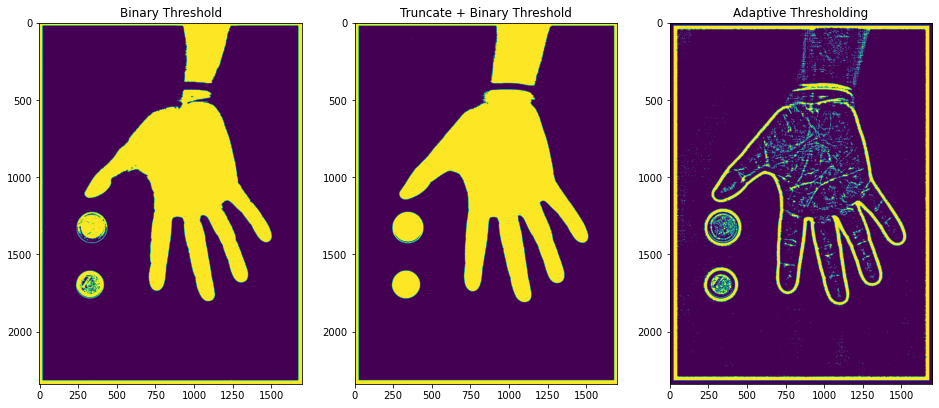

In [5]:
fig, (ax1, ax2, ax3) = subplots(1,3, figsize=(16,10))
ax1.title.set_text('Binary Threshold')
ax2.title.set_text('Truncate + Binary Threshold')
ax3.title.set_text('Adaptive Thresholding')
ax1.imshow(thresh1)
ax2.imshow(thresh2)
ax3.imshow(thresh3)
show()

The problem here is that having just one threshold value does not suffice. Due to variations in lighting conditions, shadowing, etc., it may be that one value will work for a certain part of the input image but will  fail on a different one.

[Image Segmentation with Watershed Algorithm](https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html)

- `Morphological opening` can be used to remove any small white noises in the image.
- `Morphological closing` can be used to remove any small holes in the objects.
- `Erosion` can be used to remove the boundary pixels which would allow to define foreground regions.
- `Dilation` increases object boundary which would allow to define background region.

In [6]:
#(What kernel size to prefer?)
#kernel = np.ones((3,3), np.uint8)
kernel = np.ones((5,5), np.uint8)

# noise removal (erosion followed by dilation)
opened = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel, iterations = 1)
#imshow(cv2.subtract(opened, opened2)) # for comparison

# fill in gaps (dilation followed by erosion)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations = 3)
#imshow(cv2.subtract(closed2, closed)) # for comparison

# Define background area (grow image regions)
dilated = cv2.dilate(closed, kernel, iterations=5) 

# Define foreground area (shrink image regions)
eroded = cv2.erode(closed, kernel, iterations=5)

# Define border (unknown region)
border = cv2.subtract(dilated, eroded)

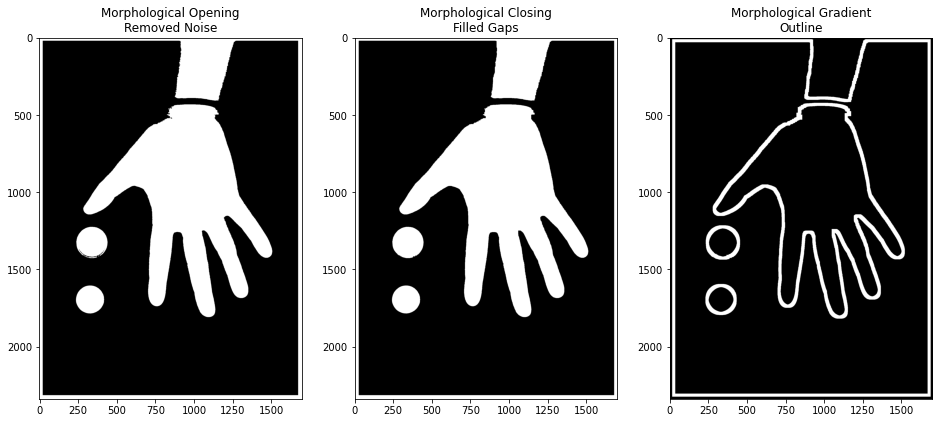

In [7]:
titles=["Morphological Opening\nRemoved Noise","Morphological Closing\nFilled Gaps", "Morphological Gradient\nOutline"]
images=[opened, closed, border]

fig, (ax1, ax2, ax3) = subplots(1,3, figsize=(16,10))
n = 3
for i in range(n):
    subplot(1, n, i+1)
    imshow(images[i], "gray")
    title(titles[i])
show()  

Next, create a marker image (an array of same size as the original image, but with `int32` datatype) and label the regions inside it.

`cv2.connectedComponents()` can be used to label the background region of the image with zeros and all other objects with integers starting from 1. Note that if the background is labeled with 0, the watershed algorithm will consider it as unknown area. 

In [8]:
closed.shape

(2338, 1700)

In [9]:
import pandas as pd
# Labeling
num_markers, img_marked = cv2.connectedComponents(closed)
#print(img_marked.dtype) # Check data type

stats = measure.regionprops_table(img_marked, img, properties=['label',
                                                               'area',
                                                               'centroid', # Geometric-center 
                                                               'bbox',
                                                               'orientation',
                                                               'major_axis_length',
                                                               'minor_axis_length',
                                                               'equivalent_diameter'])
df = pd.DataFrame(stats)
df.head()

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,orientation,major_axis_length,minor_axis_length,equivalent_diameter
0,1,311881,814.968882,933.549896,0,0,2338,1700,-0.110494,3453.325091,2276.884770,630.158093
1,2,717639,1049.867033,952.888805,435,286,1809,1508,0.284223,1323.211517,908.521968,955.890346
2,3,32003,1326.405743,341.610755,1226,241,1428,443,-0.723018,202.435275,201.323650,201.860063
3,4,25687,1694.685405,329.535446,1605,239,1786,421,-1.170238,181.752113,179.954276,180.847185


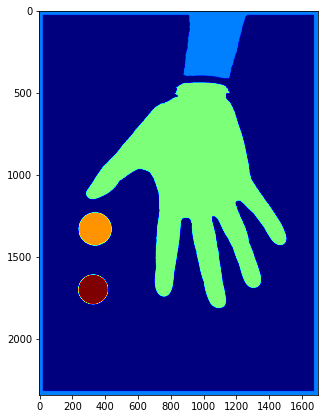

In [10]:
#rotated = ndimage.rotate(img_marked, np.degrees(-0.27), reshape=False)
figure(figsize=(5,10))
imshow(img_marked, cmap='jet')
show()

In [11]:
# Isolate hand segment
hand_index = df['area'].idxmax() + 1
hand = where(img_marked == hand_index, np.uint8(255), np.uint8(0))
allowed_margin = [axis / 30 for axis in hand.shape] # 30% of image size

In [12]:
# Descriptive information (geometric centre, major/minor axes, orientation)
y0_centre = df.loc[df["label"] == hand_index]['centroid-0'].item()
x0_centre = df.loc[df["label"] == hand_index]['centroid-1'].item()
radius0 = df.loc[df["label"] == hand_index].major_axis_length / 8.0

orientation = df.loc[df['label'] == hand_index]['orientation'].item()
minor_axis_length = df.loc[df['label'] == hand_index]['minor_axis_length'].item()
major_axis_length = df.loc[df['label'] == hand_index]['major_axis_length'].item()

In [13]:
# major and minor axes of a segment
x1 = x0_centre + cos(orientation) * 0.5 * minor_axis_length
y1 = y0_centre - sin(orientation) * 0.5 * minor_axis_length
x2 = x0_centre - sin(orientation) * 0.5 * major_axis_length
y2 = y0_centre - cos(orientation) * 0.5 * major_axis_length

In [14]:
# Downhill optimization
def lossFunction(params):
    isInside = 1
    x0, y0, r = params
    coords = draw.disk((y0, x0), r, shape=hand.shape)
    template = np.zeros_like(hand)
    template[coords] = 255
    
    if count_nonzero(cv2.subtract(template, hand)) > 0:
        isInside = 0
    elif abs(y0 - y0_centre) > allowed_margin[0] or abs(x0 - x0_centre) > allowed_margin[1]:
        isInside = 0
        
    return -np.sum(template == hand) * isInside

x_centre, y_centre, radius = optimize.fmin(lossFunction, (x0_centre, y0_centre, radius0))

diameter = 2 * radius
print("Circle Diameter: %.3f" % (diameter))

Optimization terminated successfully.
         Current function value: -3514058.000000
         Iterations: 112
         Function evaluations: 223
Circle Diameter: 572.154


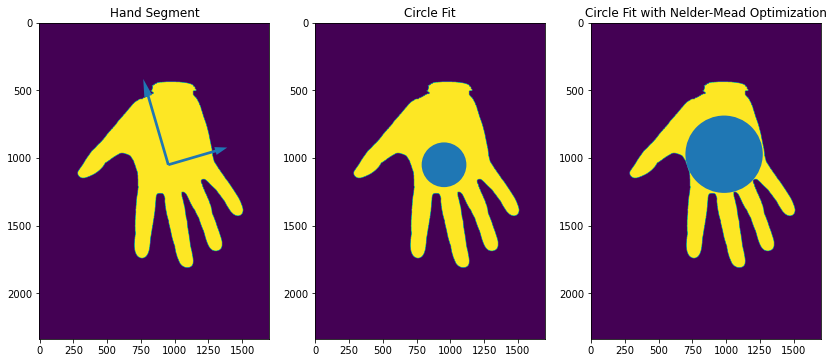

In [15]:
fig, (ax1, ax2, ax3) = subplots(1,3, figsize=(14,10))
ax1.title.set_text("Hand Segment")
ax2.title.set_text("Circle Fit")
ax3.title.set_text("Circle Fit with Nelder-Mead Optimization")
ax1.imshow(hand)
ax2.imshow(hand)
ax3.imshow(hand)

a1 = Arrow(x0_centre, y0_centre, x1-x0_centre, y1-y0_centre, width=100.0)
a2 = Arrow(x0_centre, y0_centre, x2-x0_centre, y2-y0_centre, width=100.0)
c0 = Circle((x0_centre, y0_centre), radius0)
c1 = Circle((x_centre, y_centre), radius)
ax1.add_artist(a1)
ax1.add_artist(a2)
ax2.add_artist(c0)
ax3.add_artist(c1)
show()

## Feature Detection
The resulting features will be subsets of the image domain, often in the form of isolated points, continuous curves or connected regions.

In [16]:
# A Convex object is one with no interior angles greater than 180 degrees.
cnts = cv2.findContours(hand, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(cnts) # Prevent compatibility issues with different versions of OpenCV
#contours[0].shape

convex_hull = [cv2.convexHull(c) for c in contours]

# Calulate Euclidean Distance between consecutive points
deltas = np.diff(convex_hull[0], axis=0)
euclidean_distances = np.sqrt((deltas ** 2).sum(axis=2))

count, edges = histogram(euclidean_distances, bins=4)

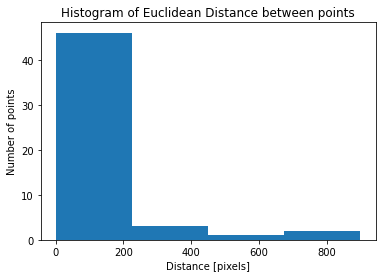

In [17]:
hist(euclidean_distances, bins=4)
title("Histogram of Euclidean Distance between points")
xlabel("Distance [pixels]")
ylabel("Number of points")
show()

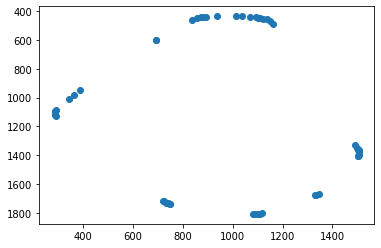

In [18]:
x_values = convex_hull[0].T[0][0]
y_values = convex_hull[0].T[1][0]
 
scatter(x_values, y_values)
gca().invert_yaxis()
show()

### KMeans - centers do not align on the tips (not good enough)

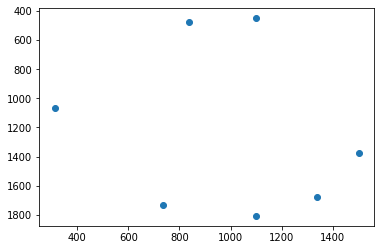

In [19]:
from sklearn.cluster import KMeans
points = convex_hull[0].reshape(-1, 2)

kmeans = KMeans(n_clusters=7, random_state=0).fit(points)
centers = kmeans.cluster_centers_
x = centers.T[0]
y = centers.T[1]
gca().invert_yaxis()
scatter(x, y)

### Manual Clustering

In [20]:
thresh_low = 20
thresh_high = 200

groups = {}
tmp = []
previous = convex_hull[0][0][0]

convex_points = convex_hull[0][1:].reshape(-1,2)
n = 0
tmp.append(previous)
for c in convex_points:
    distance = np.linalg.norm(previous-c)

    if distance > thresh_high and tmp:
        groups[n] = np.array(tmp)
        tmp = []
        n += 1

    if distance < thresh_low:
        tmp.append(c)

    previous = c

In [21]:
side = "right"
labels = ["thumb", "index", "middle", "ring", "pinky"]
if side == "right":
        labels = labels[::-1]

def getAverage(points):
    return int(sum(points[0]) / len(points[0])), int(sum(points[1]) / len(points[1]))

def labelPoints(groups, labels):
    points = {}
    
    for key in groups.keys():
        points[key] = getAverage(groups[key].T)
        
    max_x, min_y = 0, gray.shape[0] 
    wristKeys = [0, 0]
    for key, value in points.items():
        if value[1] < min_y:
            min_y = value[1]
            wristKeys[0] = key
        
        if value[0] > max_x:
            max_x = value[0]
            wristKeys[1] = key
            
    if wristKeys[0] == wristKeys[1]:
        wristKeys[1] += 1
        
    counter = 0
    for key in points.fromkeys(points):
        if key >= wristKeys[1] and key < wristKeys[1] + 5:
            points[labels[counter]] = points.pop(key)
            counter += 1
        else:
            if key != wristKeys[0]:
                points.pop(key)
                
    points["wrist"] = points.pop(wristKeys[0])
    return points
    
labelPoints(groups, labels)

{'pinky': (1504, 1387),
 'ring': (1333, 1678),
 'middle': (1095, 1807),
 'index': (735, 1728),
 'thumb': (288, 1104),
 'wrist': (1105, 451)}

### Construct projections, reference lines, and calculate distance between points

In [22]:
def getSlopeIntercept(point1, point2):
    """Compute slope and intercept of line"""
    x1, y1 = point1
    x2, y2 = point2
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return a, b

def lineAt(a, b, x):
    """Compute y of line at x"""
    return a * x + b

def vertDistFingers(tip1, tip2, a, b):
    """Compute vertical distance between fingers"""
    dist1 = tip1[1] - lineAt(a, b, tip1[0])
    dist2 = tip2[1] - lineAt(a, b, tip2[0])
    return abs(dist1 - dist2)

def horDistFingers(tip1, tip2, a, b):
    """Compute horizontal distance between fingers"""
    line_point1 = numpy.array([tip1[0], lineAt(a, b, tip1[0])])
    line_point2 = numpy.array([tip2[0], lineAt(a, b, tip2[0])])
    
    dist = numpy.linalg.norm(line_point1-line_point2)
    return dist

In [24]:
points = labelPoints(groups, labels)

wrist_point = points["wrist"]
wrist_point2 = (wrist_point[0] + 1, wrist_point[1])

wrist_slope, wrist_intercept = getSlopeIntercept(wrist_point, wrist_point2)
#center_slope, center_intercept = getSlopeIntercept(center_point, minor_axis_point)

# Needed for visualization
#center_point = (x0_centre, y0_centre)
major_axis_point = (x2, y2)
minor_axis_point = (x1, y1)

wrist_line_0 = lineAt(wrist_slope, wrist_intercept, 0) 
wrist_line_end = lineAt(wrist_slope, wrist_intercept, hand.shape[1] - 1)
  
# center_line_0 = lineAt(center_slope, center_intercept, 0) - y2 
# center_line_end = lineAt(center_slope, center_intercept, hand.shape[1] - 1) - y2

### Calculate pixel per mm ratio from reference objects - Euro coins

In [25]:
df[["label", "area", "equivalent_diameter"]]

,label,area,equivalent_diameter
0,1,311881,630.158093
1,2,717639,955.890346
2,3,32003,201.860063
3,4,25687,180.847185


In [26]:
# Isolate coin segments
# coin1 -> 1 Euro coin
# coin2 -> 2 Euro coin
# pixels_per_metric = object_width / know_width

In [27]:
size_coin1 = 23.25 # [mm] 
index_coin1 = df.loc[df['area'] < 30000].label.item()
diameter_coin1 = df.loc[df['label'] == index_coin1].equivalent_diameter.item()
coin1 = where(img_marked == index_coin1, np.uint8(255), np.uint8(0))

In [28]:
size_coin2 = 25.75 # [mm] 
index_coin2 = df.loc[(df['area'] > 30000) & (df['area'] < 35000)].label.item()
diameter_coin2 = df.loc[df['label'] == index_coin2].equivalent_diameter.item()
coin2 = where(img_marked == index_coin2, np.uint8(255), np.uint8(0))

In [29]:
pixels_per_mm_1 = diameter_coin1 / size_coin1
pixels_per_mm_2 = diameter_coin2 / size_coin2
pixels_per_cm = (pixels_per_mm_1 + pixels_per_mm_2) * 0.5 * 10

In [30]:
diameter_coin1 / pixels_per_cm * 10, diameter_coin2 / pixels_per_cm * 10, 

(23.159408978809797, 25.85033199121066)

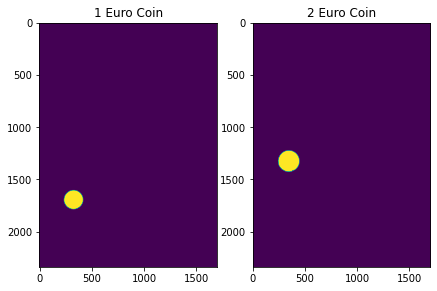

In [31]:
fig, (ax1, ax2) = subplots(1,2, figsize=(7,10))
ax1.title.set_text('1 Euro Coin')
ax2.title.set_text('2 Euro Coin')
ax1.imshow(coin1)
ax2.imshow(coin2)
show()

### PyPlot Visualize

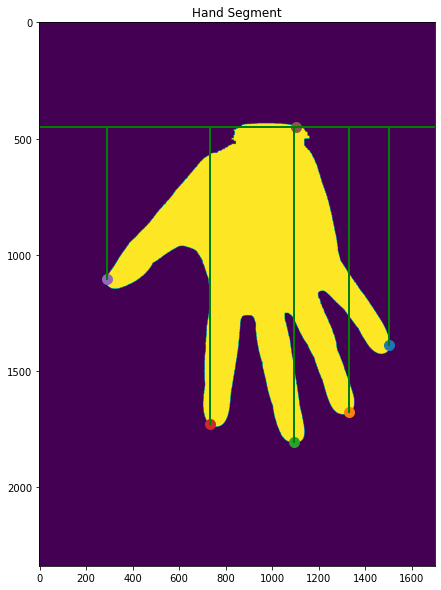

In [32]:
fig, ax1 = subplots(1,1, figsize=(14,10))
ax1.title.set_text("Hand Segment")
ax1.imshow(hand)

size = 100
for label, point in points.items():
    ax1.scatter(point[0], point[1], s=size)

plot([0, hand.shape[1] - 1], [wrist_line_0, wrist_line_end], 'g-', lw=2)
#plot([0, hand.shape[1] - 1], [center_line_0, center_line_end], 'g-', lw=2)
for label, point in points.items():
    point_on_line = lineAt(wrist_slope, wrist_intercept, point[0])
    plt.plot([point[0], point[0]], [point[1], point_on_line], 'g-', lw=2)
show()

### Take Measurements

In [33]:
width = diameter / pixels_per_cm
length = vertDistFingers(points["middle"], wrist_point, wrist_slope, wrist_intercept) / pixels_per_cm
distance_1_2 = vertDistFingers(points["thumb"], points["index"], wrist_slope, wrist_intercept) / pixels_per_cm
distance_1_3 = vertDistFingers(points["thumb"], points["middle"], wrist_slope, wrist_intercept) / pixels_per_cm
distance_2_3 = vertDistFingers(points["index"], points["middle"], wrist_slope, wrist_intercept) / pixels_per_cm
distance_2_5 = horDistFingers(points["index"], points["pinky"], wrist_slope, wrist_intercept) / pixels_per_cm
distance_1_5 = horDistFingers(points["thumb"], points["pinky"], wrist_slope, wrist_intercept) / pixels_per_cm


print("Hand Width: %.2f cm" % width)
print("Hand Length: %.2f cm" % length)
print("1) Vertical distance between thumb and index: %.2f cm" % distance_1_2)
print("2) Vertical distance between thumb and middle: %.2f cm" % distance_1_3)
print("3) Vertical distance between index and middle: %.2f cm" % distance_2_3)
print("4) Horizontal distance between index and pinky: %.2f cm" % distance_2_5)
print("5) Horizontal distance between thumb and pinky: %.2f cm" % distance_1_5)

Hand Width: 7.33 cm
Hand Length: 17.37 cm
1) Vertical distance between thumb and index: 7.99 cm
2) Vertical distance between thumb and middle: 9.00 cm
3) Vertical distance between index and middle: 1.01 cm
4) Horizontal distance between index and pinky: 9.85 cm
5) Horizontal distance between thumb and pinky: 15.57 cm


### OpenCV Visualize

In [34]:
cv2.line(img, (0, int(wrist_line_0)), (int(hand.shape[1] - 1), int(wrist_line_end)), (0, 255, 0), thickness=3)
for label, point in points.items():
    point_on_line = lineAt(wrist_slope, wrist_intercept, point[0])
    cv2.circle(img, (point[0], point[1]), radius=5, color = (0, 0, 255), thickness=10)
    cv2.line(img, (int(point[0]), int(point[1])), (int(point[0]), int(point_on_line)), (0, 255, 0), thickness=2)
    cv2.putText(img, label, (point[0], point[1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

In [ ]:
# cv2.namedWindow('ConvexHull',cv2.WINDOW_NORMAL)
# cv2.imshow('ConvexHull',img)
# cv2.waitKey(1000)
# cv2.destroyAllWindows()
#cv2.imwrite("out.jpg", img)